**1 Przygotowanie datasetu do treningu modelu**

W celu wytrenowania modelu udostepnilismy zbior treningowy UCDS Peds1 w Google Drive - skladajacego sie z 32 filmow bez anomalii (w tym przypadku pokazujemy tylko jego czesc - filmy 1-8).

Po zamontowaniu google drive do google colab otrzymujemy widocznosc dodatkowego folderu (`drive`) ; a po uzyciu funkcji systemowej `!ls` mozemy wyswietlic nasz zbior treningowy (widzimy np. 200 klatek w formacie `.tif` dla filmu Train001).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/datasets2/UCSD1/train

Train001  Train002  Train003  Train004	Train005  Train006  Train007  Train008


In [3]:
!ls drive/MyDrive/datasets2/UCSD1/train/Train001

001.tif  020.tif  039.tif  058.tif  077.tif  096.tif  115.tif  134.tif	153.tif  172.tif  191.tif
002.tif  021.tif  040.tif  059.tif  078.tif  097.tif  116.tif  135.tif	154.tif  173.tif  192.tif
003.tif  022.tif  041.tif  060.tif  079.tif  098.tif  117.tif  136.tif	155.tif  174.tif  193.tif
004.tif  023.tif  042.tif  061.tif  080.tif  099.tif  118.tif  137.tif	156.tif  175.tif  194.tif
005.tif  024.tif  043.tif  062.tif  081.tif  100.tif  119.tif  138.tif	157.tif  176.tif  195.tif
006.tif  025.tif  044.tif  063.tif  082.tif  101.tif  120.tif  139.tif	158.tif  177.tif  196.tif
007.tif  026.tif  045.tif  064.tif  083.tif  102.tif  121.tif  140.tif	159.tif  178.tif  197.tif
008.tif  027.tif  046.tif  065.tif  084.tif  103.tif  122.tif  141.tif	160.tif  179.tif  198.tif
009.tif  028.tif  047.tif  066.tif  085.tif  104.tif  123.tif  142.tif	161.tif  180.tif  199.tif
010.tif  029.tif  048.tif  067.tif  086.tif  105.tif  124.tif  143.tif	162.tif  181.tif  200.tif
011.tif  030.tif  049.tif  068

**2 Instalacja niezbednych bibliotek**

Nasz model uzywa biblioteki keras-layer-normalization, ktora nie jest 'defaultowo' zainstalowana w google colab. To jedyna biblioteka ktorej instalacja w trybie 'explicite' jest niezbedna.

In [ ]:
!pip install keras-layer-normalization

**3 Plik konfiguracyjny**

W celu ulatwienia pracy tworzymy prosty plik konfiguracyjny, ktory zawiera sciezke do zbioru treningowego, sciezke do pojedynczego filmu testowego, sciezke do miejsca w ktorym zapiszemy nasz wytrenowany model, oraz dwie zmienne uzywane w trakcie treningu - zmienne te (batch size oraz epochs) sa ustawione na bardzo niskie, poniewaz ten notatnik zawierajacy kod zrodlowy jest notatnikiem podgladowym, wlasciwy trening odbywal sie w innej jego instancji : epochs = 1 pokazuje, ze model jest kompilowalny, a batch size = 2 zmniejsza potrzebny naklad GPU_RAM potrzebny do treningu.

In [ ]:
class Config:
  DATASET_PATH ="drive/MyDrive/datasets2/UCSD1/train"
  SINGLE_TEST_PATH = "drive/MyDrive/datasets2/UCSD1/train/Train007"
  BATCH_SIZE = 2
  EPOCHS = 1
  MODEL_PATH = "./model.hdf5"

**4 Przygotowanie training_setu**

Aby przygotowac training set iterujemy po wszystkich folderach wewnatrz sciezki prowadzacej do Train, gdzie w kazdym folderze mamy inny film podzielony na klatki. Dla kazdego folderu klatki te sortujemy, wczytujemy, uzywamy operacji resize przeksztalcajac je na wymiar 256x256, nastepnie normalizujemy kazda wartosc rzutujac ja do [0-1), a nastepnie przy pomocy funkcji get_clips_by_stride() oknujemy nasze filmy tworzac sekwencje dziesiecioklatkowe. W ten sposob z jednego filmu o 200 klatkach uzyskujemy tablice numpy o rozmiarze (191, 10, 256, 256, 1) (ostatni wymiar to 1 poniewaz filmy sa juz w odcieniu szarosci). Podobnie robimy dla filmu testowego uzywajac funkcji get_single_test() pobierajacej klatki ze sciezki dla filmu testowego, a nastepnie konwertujac do tablicy numpy i oknujac.

In [ ]:
def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips

In [ ]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips


In [ ]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

**5 Model**

W naszym modelu uzywamy architektury autoencodera o formacie 2DCNN-LSTM-2DCNN. Model sklada sie z dwoch warst konwolucyjnych , po ktorych nastepuja trzy warstwy ConvLSTM badajace warstwe temporalna filmu ; po ktorych znowu wystepuja warsty konwolucyjne, teraz oczywiscie upsamplingujac nasze wymiary. Widzimy, ze model ma w sumie 1958209 parametrow, z czego wszystkie sa trenowalne.

In [ ]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,256,256,1)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-6 ))#decay=1e-5, ))
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

In [ ]:
model = get_model(True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 7, 64, 64, 128)    15616     
 ributed)                                                        
                                                                 
 layer_normalization (Layer  (None, 7, 64, 64, 128)    256       
 Normalization)                                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 7, 32, 32, 64)     204864    
 stributed)                                                      
                                                                 
 layer_normalization_1 (Lay  (None, 7, 32, 32, 64)     128       
 erNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 7, 32, 32, 64)     2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Ewaluacja Modelu**

Nastepnie dokonujemy ewaluacji wytrenowanego wczesniej (wczesniej - czyli nie w tej poprzedniej komorce, gdzie trenujemy go przez jedna epoke) modelu dla filmu testowego. W tym fragmencie kodu obliczany jest tzw. "regularity score" dla sekwencji danych. Obliczamy koszt rekonstrukcji sekwencji (sequences_reconstruction_cost - gdzie np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) oblicza normę (długość) różnicy między oryginalną a zrekonstruowaną sekwencją) - jest to miara błędu rekonstrukcji dla każdej sekwencji. Nastepnie normalizujemy koszt rekonstrukcji (dzielimy przez np.max(sequences_reconstruction_cost) co skaluje koszty do zakresu [0, 1] - po tej operacji, `sa` zawiera znormalizowane koszty rekonstrukcji dla każdej sekwencji). Na koniec Obliczamy "regularity score" jako `1.0 - sa`, ponieważ sa jest znormalizowanym kosztem rekonstrukcji. Wysoki koszt rekonstrukcji (niska wartość w sa) skutkuje niskim wynikiem w sr (wysoka wartość), co oznacza, że sekwencja jest nieregularna lub odstająca. Niski koszt rekonstrukcji (wysoka wartość w sa) daje wysoki wynik w sr, co wskazuje na sekwencję regularną.

In [ ]:
import matplotlib.pyplot as plt

def evaluate():
    model = get_model(True)
    print("got model")
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 7, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 64, 64, 128)   15616     
 ributed)                                                        
                                                                 
 layer_normalization (Layer  (None, 10, 64, 64, 128)   256       
 Normalization)                                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 32, 32, 64)    204864    
 stributed)                                                      
                                                                 
 layer_normalization_1 (Lay  (None, 10, 32, 32, 64)    128       
 erNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 32, 32, 64)    2

None
Epoch 1/3
80/80 [==============================] - 179s 2s/step - loss: 0.1858
Epoch 2/3
80/80 [==============================] - 135s 2s/step - loss: 0.1853
Epoch 3/3
80/80 [==============================] - 138s 2s/step - loss: 0.1853


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


got model
(200, 256, 256, 1)
got data
48/48 [==============================] - 29s 570ms/step


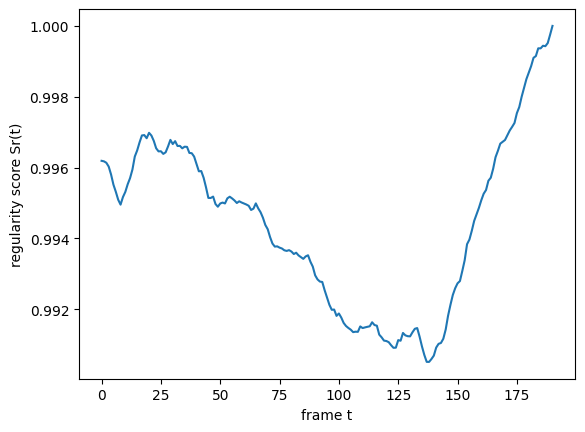

In [ ]:
evaluate()


**DALSZA CZESC ZAWIERA TRESC W STANIE DEVELOPERSKIM**

In [ ]:
modell = load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})

In [ ]:
modell

In [ ]:
test = get_single_test()

In [ ]:
test.shape

(200, 256, 256, 1)

In [ ]:
test[0].shape

(256, 256, 1)

In [ ]:
test

array([[[[0.4375    ],
         [0.41796875],
         [0.359375  ],
         ...,
         [0.2109375 ],
         [0.28515625],
         [0.3125    ]],

        [[0.3671875 ],
         [0.35546875],
         [0.3515625 ],
         ...,
         [0.2109375 ],
         [0.26953125],
         [0.34375   ]],

        [[0.28515625],
         [0.28125   ],
         [0.34375   ],
         ...,
         [0.21875   ],
         [0.25      ],
         [0.37890625]],

        ...,

        [[0.50390625],
         [0.51171875],
         [0.515625  ],
         ...,
         [0.6875    ],
         [0.6875    ],
         [0.76953125]],

        [[0.515625  ],
         [0.515625  ],
         [0.51953125],
         ...,
         [0.6953125 ],
         [0.69921875],
         [0.78515625]],

        [[0.51953125],
         [0.515625  ],
         [0.51953125],
         ...,
         [0.703125  ],
         [0.70703125],
         [0.80078125]]],


       [[[0.42578125],
         [0.39453125],
         [0.36

In [ ]:
sz = test.shape[0] - 10 + 1
sequences = np.zeros((sz, 10, 256, 256, 1))
# apply the sliding window technique to get the sequences
for i in range(0, sz):
    clip = np.zeros((10, 256, 256, 1))
    for j in range(0, 10):
        clip[j] = test[i + j, :, :, :]
    sequences[i] = clip

In [ ]:
sequences

numpy.ndarray

In [ ]:
np.save('input.npy',sequences)

In [ ]:
!ls

1Ug1upTdWdWKL9WsMgkzuW7KQZOUY0Gtt  drive  input.npy  model.hdf5  sample_data


In [ ]:
from google.colab import files
files.download('input.npy')


In [ ]:
np.save('input_notsequenced.npy', test)

In [ ]:
from google.colab import files
files.download('input_notsequenced.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

48/48 [==============================] - 20s 419ms/step


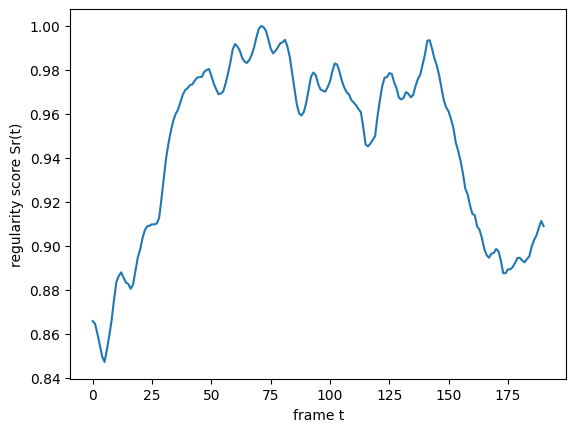

In [ ]:
reconstructed_sequences = modell.predict(sequences,batch_size=4)
sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
sr = 1.0 - sa

# plot the regularity scores
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

In [ ]:
import boto3
import sagemaker
from sagemaker import get_execution_role
sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

prefix = 'xlmrlarge/' #Replace with the prefix under which you want to store the data if needed

In [ ]:
import h5py
modelpath = './model.hdf5'
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
modell = load_model(modelpath,custom_objects={'LayerNormalization': LayerNormalization})
import numpy as np
test = np.load('./input_notsequenced.npy')











In [ ]:
sz = test.shape[0] - 10 + 1
sequences = np.zeros((sz, 10, 256, 256, 1))
# apply the sliding window technique to get the sequences
for i in range(0, sz):
    clip = np.zeros((10, 256, 256, 1))
    for j in range(0, 10):
        clip[j] = test[i + j, :, :, :]
    sequences[i] = clip
sequences = sequences[0:25]

In [ ]:
sequences = sequences.astype(np.float32)

In [ ]:
reconstructed_sequences = modell.predict(sequences,batch_size=1)





In [ ]:
import matplotlib.pyplot as plt

sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sequences.shape[1])])
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
sr = 1.0 - sa

# plot the regularity scores
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

In [ ]:
save_path = "/home/ec2-user/SageMaker/model/1/"
tf.saved_model.save(modell, save_path)

In [ ]:
!tar -czvf xlmrlarge.tar.gz model/1/

In [ ]:
#!unzip /home/ec2-user/SageMaker/xlmrlarge.tar.gz

!tar -xf /home/ec2-user/SageMaker/xlmrlarge.tar.gz -C --absolute-names /home/ec2-user/SageMaker/

In [ ]:
#model_data =  "s3://anomaly-model3/xlmrlarge/model/xlmrlarge.tar.gz"
bucket_name = 'anomaly-model3'
model_data = sess.upload_data(path='xlmrlarge.tar.gz', bucket=bucket_name, key_prefix = prefix+"model") #, key_prefix = prefix+"mod
model_data

In [ ]:
from sagemaker.utils import name_from_base
from sagemaker.tensorflow import TensorFlowModel

In [ ]:
predictor = model.deploy(initial_instance_count=1,   instance_type='ml.t2.medium')

In [ ]:
predictor.delete_endpoint()

In [ ]:

model_dir = './model/1'
model = tf.saved_model.load(model_dir)
predictions = model(sequences2)

In [ ]:
# S3 prefix
prefix = "DEMO-scikit-iris"

import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = get_execution_role()

import boto3
import numpy as np
import pandas as pd
import os

os.makedirs("./data", exist_ok=True)

s3_client = boto3.client("s3")
s3_client.download_file(
    f"sagemaker-example-files-prod-{region}", "datasets/tabular/iris/iris.data", "./data/iris.csv"
)

df_iris = pd.read_csv("./data/iris.csv", header=None)
df_iris[4] = df_iris[4].map({"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2})
iris = df_iris[[4, 0, 1, 2, 3]].to_numpy()
np.savetxt("./data/iris.csv", iris, delimiter=",", fmt="%1.1f, %1.3f, %1.3f, %1.3f, %1.3f")

WORK_DIRECTORY = "data"

train_input = sagemaker_session.upload_data(
    WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY)
)



In [ ]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "1.2-1"
script_path = "scikit_learn_iris.py"

sklearn = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.m2.medium",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={"max_leaf_nodes": 30},
)

In [ ]:
sklearn.fit({"train": train_input})

In [ ]:
predictor = sklearn.deploy(initial_instance_count=1, instance_type="ml.m2.medium")

In [ ]:
import itertools
import pandas as pd

shape = pd.read_csv("data/iris.csv", header=None)

a = [50 * i for i in range(3)]
b = [40 + i for i in range(10)]
indices = [i + j for i, j in itertools.product(a, b)]

test_data = shape.iloc[indices[:-1]]
test_X = test_data.iloc[:, 1:]
test_y = test_data.iloc[:, 0]

In [ ]:
print(predictor.predict(test_X.values))
print(test_y.values)

In [ ]:
from __future__ import print_function

import argparse
import joblib
import os
import pandas as pd

from sklearn import tree


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here. In this simple example we are just including one hyperparameter.
    parser.add_argument('--max_leaf_nodes', type=int, default=-1)

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args = parser.parse_args()

    # Take the set of files and read them all into a single pandas dataframe
    input_files = [ os.path.join(args.train, file) for file in os.listdir(args.train) ]
    if len(input_files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(args.train, "train"))
    raw_data = [ pd.read_csv(file, header=None, engine="python") for file in input_files ]
    train_data = pd.concat(raw_data)

    # labels are in the first column
    train_y = train_data.iloc[:, 0]
    train_X = train_data.iloc[:, 1:]

    # Here we support a single hyperparameter, 'max_leaf_nodes'. Note that you can add as many
    # as your training my require in the ArgumentParser above.
    max_leaf_nodes = args.max_leaf_nodes

    # Now use scikit-learn's decision tree classifier to train the model.
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes)
    clf = clf.fit(train_X, train_y)

    # Print the coefficients of the trained classifier, and save the coefficients
    joblib.dump(clf, os.path.join(args.model_dir, "model.joblib"))


def model_fn(model_dir):
    """Deserialized and return fitted model

    Note that this should have the same name as the serialized model in the main method
    """
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf